# Library installations

In [1]:
!pip install torch-geometric spektral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.7 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 12.3 MB/s eta 0:00:00


# Data preprocessing

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.optim import AdamW
from torch_geometric.nn import GATConv

In [3]:
tweets_df = pd.read_csv('/kaggle/input/twitter-mbti-dataset/user_tweets.csv', dtype='unicode')
labels_df = pd.read_csv('/kaggle/input/twitter-mbti-dataset/mbti_labels.csv')
info_df = pd.read_csv('/kaggle/input/twitter-mbti-dataset/user_info.csv')
edges_df = pd.read_csv('/kaggle/input/twitter-mbti-dataset/edges.csv')

In [4]:
print('Is there any missing values in tweets data set:\n')
# print(tweets_df.isnull().any())
tweets_df = tweets_df.dropna()
print(tweets_df.shape)
tweets_df.head(1)

Is there any missing values in tweets data set:

(4215, 201)


,id,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,tweet_9,...,tweet_191,tweet_192,tweet_193,tweet_194,tweet_195,tweet_196,tweet_197,tweet_198,tweet_199,tweet_200
0,160881623,@andresitonieve Me he quedado igual estoy llor...,RT @heikala_art: Fragment of a Star 💫 Celebrat...,RT @bananamisart: I heard it was BOtW's 3rd an...,RT @night_sprout: new banner time!! https://t....,RT @dealer_rug: Why is everyone buying toilet ...,@andresitonieve Amo el diseño de este personaje,RT @Tchaigothsky: UNFORTUNATELY I CANT STOP WA...,RT @_Ritao_: IT'S SO CUTE AHHHHHHH😭 https://t....,RT @Lesfleursdmal: Os dejo esto por aquí por s...,...,NOOOOOOOOOOO MURCIA HA CAÍDO TAMBIÉN 😔😔😔,@ederugaruto Si te están amenazando de esa man...,19. Siempre me han encantado los días de fuego...,RT @pupa_puuupa: 4〜6 https://t.co/Hhdv33tWOi,RT @TANA_in_: 뜨거운 여름 밤은 가고 남은 건 볼품없지만 https://...,RT @Vivi95862484: ❤️💙 https://t.co/OAv2F1FKLc,RT @gomachino: ミツナルの日 https://t.co/9b44lJtHDW,RT @_KUZUDANA_: ❤️ミツナルの日💙 https://t.co/7wCGN8Wgl9,RT @Locarconio: 🔴 Ciertos youtubers están en M...,RT @charllandsberg: Asexual women in South Afr...


In [5]:
print('Is there any missing values in info data set:\n')
# print(info_df.isnull().any())

info_df = info_df.dropna()
print(info_df.shape)
info_df.head(1)

Is there any missing values in info data set:

(7077, 28)


,id,id_str,name,screen_name,location,description,verified,followers_count,friends_count,listed_count,...,total_mentions_count,total_media_count,number_of_tweets_scraped,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count
0,160881623,160881623,Biam 🍃 32 Days AC 🌴🌹,_AiBiam,Hateno Village,🐸 {INFP}{ESP/ENG} • Current obsession: Unchart...,False,1904,782,67,...,139,114,200.0,11.785,3003.58,0.98,0.25,0.185,0.695,0.57


In [6]:
print('Is there any missing values in labels data set:\n')
# print(labels_df.isnull().any())

labels_df.head(1)

Is there any missing values in labels data set:



,id,mbti_personality
0,160881623,infp


In [7]:
print('Is there any missing values in edges data set:\n')
# print(edges_df.isnull().any())

edges_df.head(1)

Is there any missing values in edges data set:



,follower_id,followee_id
0,5660312,1654576440


In [8]:
# Convert 'id' column to string type in all DataFrames
tweets_df['id'] = tweets_df['id'].astype(str)
tweets_df.fillna("no data", inplace=True)
labels_df['id'] = labels_df['id'].astype(str)
info_df['id'] = info_df['id'].astype(str)
info_df.fillna("no data", inplace=True)

# Merge datasets
data = tweets_df.merge(labels_df, on="id").merge(info_df, on="id")

data.head(1)

,id,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,tweet_9,...,total_mentions_count,total_media_count,number_of_tweets_scraped,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count
0,160881623,@andresitonieve Me he quedado igual estoy llor...,RT @heikala_art: Fragment of a Star 💫 Celebrat...,RT @bananamisart: I heard it was BOtW's 3rd an...,RT @night_sprout: new banner time!! https://t....,RT @dealer_rug: Why is everyone buying toilet ...,@andresitonieve Amo el diseño de este personaje,RT @Tchaigothsky: UNFORTUNATELY I CANT STOP WA...,RT @_Ritao_: IT'S SO CUTE AHHHHHHH😭 https://t....,RT @Lesfleursdmal: Os dejo esto por aquí por s...,...,139,114,200.0,11.785,3003.58,0.98,0.25,0.185,0.695,0.57


In [9]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions and hashtags
    text = re.sub(r"\d+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Clean all tweets
tweet_columns = [col for col in data.columns if "tweet_" in col and len(col)<= len('tweet_195')]
columns = ['name', 'screen_name',	'location',	'description']
for i in columns:
    tweet_columns.append(i)

for col in tweet_columns:
    data[col] = data[col].fillna("").apply(clean_text)
    
data.head(1)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,tweet_9,...,total_mentions_count,total_media_count,number_of_tweets_scraped,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count
0,160881623,quedado igual estoy llorando,rt fragment star 💫 celebrating anniversary bot...,rt heard botws rd anniversary ive playing lot ...,rt new banner time,rt everyone buying toilet paper it’s coronavir...,amo el diseño de este personaje,rt unfortunately cant stop watching tiktok man...,rt cute ahhhhhhh😭,rt os dejo esto por aquí por si estáis teniend...,...,139,114,200.0,11.785,3003.58,0.98,0.25,0.185,0.695,0.57


In [10]:
# Handle NaN values and ensure all entries are strings
data["all_tweets"] = data[tweet_columns].apply(
    lambda x: " ".join(x.fillna("").astype(str)), axis=1
)

data.drop('mbti_personality', axis=1, inplace=True)

data.head(1)

/tmp/ipykernel_30/1171042015.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data["all_tweets"] = data[tweet_columns].apply(


,id,tweet_1,tweet_2,tweet_3,tweet_4,tweet_5,tweet_6,tweet_7,tweet_8,tweet_9,...,total_media_count,number_of_tweets_scraped,average_tweet_length,average_retweet_count,average_favorite_count,average_hashtag_count,average_url_count,average_mentions_count,average_media_count,all_tweets
0,160881623,quedado igual estoy llorando,rt fragment star 💫 celebrating anniversary bot...,rt heard botws rd anniversary ive playing lot ...,rt new banner time,rt everyone buying toilet paper it’s coronavir...,amo el diseño de este personaje,rt unfortunately cant stop watching tiktok man...,rt cute ahhhhhhh😭,rt os dejo esto por aquí por si estáis teniend...,...,114,200.0,11.785,3003.58,0.98,0.25,0.185,0.695,0.57,quedado igual estoy llorando rt fragment star ...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

charngram_tfv = TfidfVectorizer(strip_accents = 'unicode', analyzer = 'char', sublinear_tf = 1)
charngram_tfv.fit(data["all_tweets"])

charngrams =  charngram_tfv.transform(data["all_tweets"])
charngrams

/opt/conda/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 290557 stored elements and shape (3714, 5891)>

In [12]:
tweet_columns.append('all_tweets')
tweet_columns.append('id_str')


data.drop(tweet_columns, axis=1, inplace=True)
data.columns

Index(['id', 'verified', 'followers_count', 'friends_count', 'listed_count',
       'favourites_count', 'statuses_count', 'number_of_quoted_statuses',
       'number_of_retweeted_statuses', 'total_retweet_count',
       'total_favorite_count', 'total_hashtag_count', 'total_url_count',
       'total_mentions_count', 'total_media_count', 'number_of_tweets_scraped',
       'average_tweet_length', 'average_retweet_count',
       'average_favorite_count', 'average_hashtag_count', 'average_url_count',
       'average_mentions_count', 'average_media_count'],
      dtype='object')

In [13]:
data = data.astype({'verified': 'int64', 'id': 'int64'})
data.dtypes

id                                int64
verified                          int64
followers_count                   int64
friends_count                     int64
listed_count                      int64
favourites_count                  int64
statuses_count                    int64
number_of_quoted_statuses         int64
number_of_retweeted_statuses      int64
total_retweet_count               int64
total_favorite_count              int64
total_hashtag_count               int64
total_url_count                   int64
total_mentions_count              int64
total_media_count                 int64
number_of_tweets_scraped        float64
average_tweet_length            float64
average_retweet_count           float64
average_favorite_count          float64
average_hashtag_count           float64
average_url_count               float64
average_mentions_count          float64
average_media_count             float64
dtype: object

In [14]:
charngrams_df = pd.DataFrame.sparse.from_spmatrix(charngrams)
charngrams_df['id'] = data['id']
data = pd.merge(data, charngrams_df, on="id")

data.head()

,id,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,number_of_quoted_statuses,number_of_retweeted_statuses,total_retweet_count,...,5881,5882,5883,5884,5885,5886,5887,5888,5889,5890
0,160881623,0,1904,782,67,133836,410600,14,103,600716,...,0,0,0,0,0,0,0,0,0,0
1,28968838,0,14135,1338,47,103794,358901,23,113,743749,...,0,0,0,0,0,0,0,0,0,0
2,135504848,0,4613,1169,70,31992,206712,5,136,1065793,...,0,0,0,0,0,0,0,0,0,0
3,33811202,0,1620,1234,71,4898,201919,88,51,465369,...,0,0,0,0,0,0,0,0,0,0
4,236506960,0,6857,6302,323,110705,192769,33,165,217440,...,0,0,0,0,0,0,0,0,0,0


In [15]:
print('Node features shape:', data.shape)
print('Labels:', labels_df.shape)

Node features shape: (3714, 5914)
Labels: (8328, 2)


In [16]:
import networkx as nx
import pandas as pd

# Suppose edges_df is a DataFrame with edges (for example, columns: 'source', 'target')
# Creating a directed graph based on a table with edges
G = nx.DiGraph()
G.add_edges_from(edges_df.values)

# Let's check the properties of the graph after creation
print(f"Number of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in the graph: {G.number_of_edges()}")

# Make sure that all nodes from data['id'] are present in the graph
labeled_nodes = set(data['id'])  # Nodes for which we have data
graph_nodes = set(G.nodes)       # Nodes that are already in the graph

# Find the nodes that are in the data, but are missing in the graph
missing_nodes = labeled_nodes - graph_nodes
print(f"Missing nodes (in data but not in graph): {len(missing_nodes)}")

# Add the missing nodes to the graph (they will be edge-free, i.e. isolated)
for node in missing_nodes:
    G.add_node(node)

# After adding all nodes, let's check the number of nodes in the graph again
print(f"Total number of nodes after adding missing ones: {G.number_of_nodes()}")

# Let's find isolated nodes, that is, nodes without edges
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated_nodes)}")

Number of nodes in the graph: 6067
Number of edges in the graph: 36466
Missing nodes (in data but not in graph): 826
Total number of nodes after adding missing ones: 6893
Number of isolated nodes: 826


In [17]:
# Normalize numerical features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical_cols = ['followers_count', 'friends_count', 'listed_count', 'favourites_count', 'statuses_count', 'number_of_quoted_statuses', 'number_of_retweeted_statuses', 'total_retweet_count', 'total_favorite_count', 'total_hashtag_count', 'total_url_count', 'total_mentions_count', 'total_media_count', 'average_tweet_length', 'average_retweet_count', 'average_favorite_count', 'average_hashtag_count', 'average_url_count', 'average_mentions_count', 'average_media_count']

data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head()

,id,verified,followers_count,friends_count,listed_count,favourites_count,statuses_count,number_of_quoted_statuses,number_of_retweeted_statuses,total_retweet_count,...,5881,5882,5883,5884,5885,5886,5887,5888,5889,5890
0,160881623,0,0.001991,0.000816,0.011699,0.228693,0.625093,0.073298,0.515,0.047223,...,0,0,0,0,0,0,0,0,0,0
1,28968838,0,0.014842,0.001396,0.008207,0.177359,0.546379,0.120419,0.565,0.058467,...,0,0,0,0,0,0,0,0,0,0
2,135504848,0,0.004837,0.001220,0.012223,0.054667,0.314667,0.026178,0.680,0.083783,...,0,0,0,0,0,0,0,0,0,0
3,33811202,0,0.001693,0.001288,0.012397,0.008369,0.307369,0.460733,0.255,0.036583,...,0,0,0,0,0,0,0,0,0,0
4,236506960,0,0.007195,0.006577,0.056400,0.189168,0.293438,0.172775,0.825,0.017093,...,0,0,0,0,0,0,0,0,0,0


In [18]:
columns = list(data.columns)
columns.remove('id')
columns.remove('verified')
columns.remove('number_of_tweets_scraped')

feature_dim = len(columns)

node_features = {
    int(row['id']): np.array(row[columns]) if len(row[columns]) == feature_dim else np.zeros(feature_dim)
    for _, row in data.iterrows()
}

nx.set_node_attributes(G, node_features, "features")

In [19]:
from sklearn import preprocessing 
  
label_encoder = preprocessing.LabelEncoder() 
labels_df['mbti_personality'] = label_encoder.fit_transform(labels_df['mbti_personality'])

# Assign labels to graph nodes
node_labels = {int(row['id']): row['mbti_personality'] for _, row in labels_df.iterrows()}

print(set(labels_df['mbti_personality'].unique()))
nx.set_node_attributes(G, node_labels, "label")

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}


In [20]:
import torch

to_remove=[]
for node in G.nodes:
    if 'features' not in G.nodes[node]:
        to_remove.append(node)
    elif 'label' not in G.nodes[node]:
        to_remove.append(node)
        

for i in to_remove:
    G.remove_node(i)

In [21]:
from sklearn.model_selection import train_test_split

# Train-test split
train_ids, test_ids = train_test_split(data['id'], test_size=0.2, random_state=42)

# Create masks for training and testing
train_mask = {node: (node in train_ids) for node in G.nodes}
test_mask = {node: (node in test_ids) for node in G.nodes}

nx.set_node_attributes(G, train_mask, "train_mask")
nx.set_node_attributes(G, test_mask, "test_mask")

In [22]:
total_nodes = G.number_of_nodes()
print(f"Total number of nodes in the graph: {total_nodes}")

Total number of nodes in the graph: 3522


# Model training

In [23]:
pyg_graph = from_networkx(G)
pyg_graph.x = torch.tensor([G.nodes[node]['features'] for node in G.nodes], dtype=torch.float)
pyg_graph.y = torch.tensor([G.nodes[node]['label'] for node in G.nodes], dtype=torch.long)

# Train-test split
train_ids, test_ids = train_test_split(data['id'], test_size=0.2, random_state=42)
pyg_graph.train_mask = torch.tensor([node in train_ids for node in G.nodes], dtype=torch.bool)
pyg_graph.test_mask = torch.tensor([node in test_ids for node in G.nodes], dtype=torch.bool)

print(f"Node feature shape: {pyg_graph.x.shape}")  # Should match the `input_dim`
print(f"Edge index shape: {pyg_graph.edge_index.shape}")

Node feature shape: torch.Size([3522, 5911])
Edge index shape: torch.Size([2, 9058])


/opt/conda/lib/python3.10/site-packages/torch_geometric/utils/convert.py:278: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  data_dict[key] = torch.as_tensor(value)


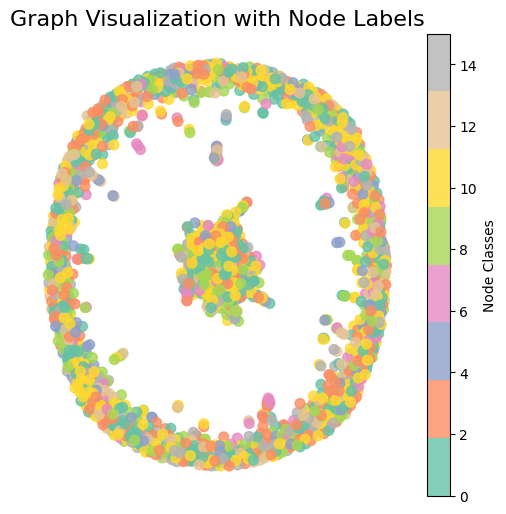

In [24]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert PyTorch Geometric Data to a NetworkX graph
nx_graph = to_networkx(pyg_graph, to_undirected=True, node_attrs=["y"])

# Get node labels for visualization (optional)
node_labels = pyg_graph.y.cpu().numpy()

# Plot the graph
plt.figure(figsize=(6, 6))
pos = nx.spring_layout(nx_graph, seed=42)  # Spring layout for better visual spacing

# Draw nodes
nodes = nx.draw_networkx_nodes(
    nx_graph, pos, node_size=50, cmap=plt.get_cmap("Set2"), 
    node_color=node_labels, alpha=0.8
)

# Draw edges
nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)

# Add colorbar for node classes
plt.colorbar(nodes, label="Node Classes")
plt.title("Graph Visualization with Node Labels", fontsize=16)
plt.axis("off")
plt.show()


In [25]:
# Task 2: Implement the GNNStack module using the GAT layer

import torch
import torch.nn as nn
from torch_geometric.nn import global_mean_pool
from torch_geometric.utils import to_dense_batch
from torch_geometric.nn import GATConv


class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        
        self.args = args
        
        self.gat0 = GATConv(input_dim, hidden_dim, heads=args['heads'], dropout=args['dropout'])
        self.gat1 = GATConv(hidden_dim * args['heads'], hidden_dim, heads=args['heads'], dropout=args['dropout'])
        self.gat2 = GATConv(hidden_dim * args['heads'], output_dim, heads=args['heads'], dropout=args['dropout'])
        
        self.fc = nn.Linear(hidden_dim * args['heads'], output_dim)

    def forward(self, data):
        
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat0(x, edge_index))
        x = F.relu(self.gat1(x, edge_index))
        x = self.gat2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return nn.functional.nll_loss(pred, label)

In [26]:
def training_step(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    predictions = model(data)
    loss = model.loss(predictions, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def test(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data)
        _, predicted_classes = predictions.max(dim=1)
        correct = (predicted_classes == data.y).sum().item()
        total = data.y.size(0)
        accuracy = correct / total
        return accuracy

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = pyg_graph.x.shape[1]
output_dim = len(label_encoder.classes_)
model = GNNStack(input_dim=input_dim, hidden_dim=64, output_dim=output_dim,
                 args={'heads': 3, 'dropout': 0.6}).to(device)


# Train GNN model
optimizer = AdamW(model.parameters(), lr=0.005)
pyg_graph = pyg_graph.to(device)


num_epochs = 1000
best_accuracy = 0.0

for epoch in range(num_epochs):
    
    loss = training_step(model, optimizer, pyg_graph)
    accuracy = test(model, pyg_graph)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
    if epoch%100==0:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss:.4f}, Test Accuracy: {accuracy*100:.2f}%")

print(f"Best Test Accuracy: {best_accuracy*100:.2f}%")

Epoch 0/1000 - Loss: 3.8681, Test Accuracy: 13.40%
Epoch 100/1000 - Loss: 2.3254, Test Accuracy: 56.90%
Epoch 200/1000 - Loss: 2.0366, Test Accuracy: 70.81%
Epoch 300/1000 - Loss: 1.9572, Test Accuracy: 74.50%
Epoch 400/1000 - Loss: 1.8609, Test Accuracy: 78.28%
Epoch 500/1000 - Loss: 1.8588, Test Accuracy: 78.79%
Epoch 600/1000 - Loss: 1.8036, Test Accuracy: 81.52%
Epoch 700/1000 - Loss: 1.8142, Test Accuracy: 82.74%
Epoch 800/1000 - Loss: 1.7755, Test Accuracy: 83.19%
Epoch 900/1000 - Loss: 1.7682, Test Accuracy: 83.84%
Best Test Accuracy: 85.60%


In [28]:
torch.save(model.state_dict(), '/kaggle/working/mbti_model.pth')

# A test on the real social page of one of the project members

In [29]:
model.load_state_dict(torch.load('/kaggle/working/mbti_model.pth', weights_only=True))

<All keys matched successfully>

In [30]:
import re
import string
import nltk
from nltk.corpus import stopwords
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import torch


nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+|#\w+", "", text)  # Remove mentions and hashtags
    text = re.sub(r"\d+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    text = " ".join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# Provided data
user_data = {
    "name": "Mariia Shmakova",
    "screen_name": "marishmak",
    "location": "Innopolis\\Russia",
    "description": "Data science\\Innopolis university",
    "followers_count": 58,
    "friends_count": 248,
    "listed_count": 21,
    "favourites_count": 2000,
    "statuses_count": 6,
    "number_of_quoted_statuses": 1,
    "number_of_retweeted_statuses": 2,
    "total_retweet_count": 2,
    "total_favorite_count": 246,
    "total_hashtag_count": 11,
    "total_url_count": 3,
    "total_mentions_count": 0,
    "total_media_count": 6,
    "average_tweet_length": 233,
    "average_retweet_count": 0.3,
    "average_favorite_count": 41,
    "average_hashtag_count": 1.8,
    "average_url_count": 0.5,
    "average_mentions_count": 0,
    "average_media_count": 1,
    "tweets": [
        "photo_update",
        "The final of the “Flying Robotics” profile of the student track of the National Technology Olympiad has been completed\n\nOrganizing university - SUAI\nPartner – Gaskar Group\n\n🥇First place:\n\nStudents of Innopolis University\n\n🏆Bugaev Gleb Olegovich, Novosibirsk\n🏆Shmakova Maria Ivanovna, Novosibirsk\n🏆Tomashov Alexander Nikolaevich, Noginsk\n🏆Okoneshnikov Dmitry Dmitrievich, Innopolis\n\n🥈Second place:\n\nStudents of National Research University 'MPEI'\n\n🏆Semenyakina Elizaveta Sergeevna, Moscow\n🏆Lipatov Alexander Alekseevich, Moscow\n🏆Chugreev Nikita Sergeevich, Moscow\n🏆Samashov Vitaly Vitalievich, Moscow\n\n🥉Third place:\n\nStudents of National Research University 'MPEI'\n\n🏆Kolomiets Yaroslav Alexandrovich, Moscow\n🏆Tolushkin Rostislav Grigorievich, Moscow\n🏆Laptashkin Grigory Vladimirovich, Moscow\n\nCongratulations to all finalists, winners and prize-winners of the profile who did not forget about #NTO after graduation!\n\n#NTOlympiad #Circle Movement #NTI #StudTrack",
        "photo update",
        "photo update",
        "photo update",
    ]
}


In [32]:
cleaned_tweets = [clean_text(tweet) for tweet in user_data["tweets"]]
all_tweets_combined = " ".join(cleaned_tweets)

In [33]:
# TF-IDF Transformation (use the trained vectorizer)
tfidf_features = charngram_tfv.transform([all_tweets_combined]).toarray()

In [34]:
# Numerical features
numerical_features = np.array([
    user_data["followers_count"],
    user_data["friends_count"],
    user_data["listed_count"],
    user_data["favourites_count"],
    user_data["statuses_count"],
    user_data["number_of_quoted_statuses"],
    user_data["number_of_retweeted_statuses"],
    user_data["total_retweet_count"],
    user_data["total_favorite_count"],
    user_data["total_hashtag_count"],
    user_data["total_url_count"],
    user_data["total_mentions_count"],
    user_data["total_media_count"],
    user_data["average_tweet_length"],
    user_data["average_retweet_count"],
    user_data["average_favorite_count"],
    user_data["average_hashtag_count"],
    user_data["average_url_count"],
    user_data["average_mentions_count"],
    user_data["average_media_count"]
]).reshape(1, -1)

In [35]:
# Normalize numerical features (use the scaler fitted during training)
normalized_numerical_features = scaler.transform(numerical_features)

# Combine all features
user_features = np.hstack([tfidf_features, normalized_numerical_features])

# Convert to PyTorch tensor
user_features_tensor = torch.tensor(user_features, dtype=torch.float)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [36]:
node_index=0

In [37]:
G.add_node(node_index)

In [38]:
feature_dim = len(columns)

node_features = {
    int(node_index): numerical_features if len(numerical_features) == feature_dim else np.zeros(feature_dim)
}

nx.set_node_attributes(G, node_features, "features")
nx.set_node_attributes(G, {node_index:0}, "label")
nx.set_node_attributes(G, {node_index:False}, "train_mask")
nx.set_node_attributes(G, {node_index:False}, "test_mask")

In [39]:

pyg_graph = from_networkx(G)
pyg_graph.x = torch.tensor([G.nodes[node]['features'] for node in G.nodes], dtype=torch.float)
pyg_graph.y = torch.tensor([G.nodes[node]['label'] for node in G.nodes], dtype=torch.long)

# Train-test split
train_ids, test_ids = train_test_split(data['id'], test_size=0.2, random_state=42)
pyg_graph.train_mask = torch.tensor([node in train_ids for node in G.nodes], dtype=torch.bool)
pyg_graph.test_mask = torch.tensor([node in test_ids for node in G.nodes], dtype=torch.bool)

print(f"Node feature shape: {pyg_graph.x.shape}")
print(f"Edge index shape: {pyg_graph.edge_index.shape}")

Node feature shape: torch.Size([3523, 5911])
Edge index shape: torch.Size([2, 9058])


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Ensure the model is on the correct device
model = model.to(device)

# Ensure graph data is on the same device
pyg_graph = pyg_graph.to(device)

# Mock inference with user features
user_features_tensor = user_features_tensor.to(device)

Using device: cuda


In [43]:
# Mock inference with user features
logits = model(pyg_graph)

In [45]:
# Assuming the last node added is the one of interest
new_node_index = pyg_graph.x.size(0) - 1

# Get logits for the specific node
node_logits = logits[new_node_index]

# Predicted MBTI class for the specific node
predicted_class = node_logits.argmax(dim=0).item()
predicted_mbti = label_encoder.inverse_transform([predicted_class])[0]

print(f"Predicted MBTI Personality: {predicted_mbti}")


Predicted MBTI Personality: intj 
